<a href="https://colab.research.google.com/github/Baroka-wp/dive_ML/blob/master/SimpleConv2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
import numpy as np
import math
import torch.nn as nn
import os
import keras
from keras import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.datasets import mnist
from keras.callbacks import TensorBoard
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import statsmodels.api as sm
from decimal import Decimal, ROUND_HALF_UP
%matplotlib inline

#### Préparation du jeu de données


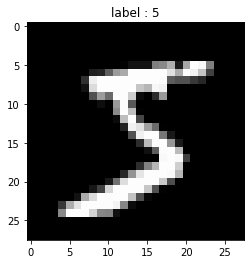

In [106]:
# chargement des donnêes
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#visualisation
index = 0
image = X_train[index].reshape(28,28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [107]:
#traiment et normalisation des données

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape, y_train.shape) # (48000, 784)
print(X_val.shape, y_val.shape) # (12000, 784)


(48000, 1, 28, 28) (48000, 10)
(12000, 1, 28, 28) (12000, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


## [Problème 1] Création d'une couche de convolution bidimensionnelle


In [108]:
class SimpleConv2d():
    def __init__(self, F, C, FH, FW, P, S,initializer=None,optimizer=None,activation=None):
        self.P = P
        self.S = S
        self.initializer = initializer
        self.optimizer = optimizer
        self.activation = activation
        self.W = self.initializer.W(F,C,FH,FW)
        self.B = self.initializer.B(F)
    

    def forward(self, X,debug=False):
      self.X = X
      N,C,H,W = self.X.shape
      F,C,FH,FW = self.W.shape
      OH,OW = self.output_shape2d(H,W,self.P,self.P,FH,FW,self.S,self.S)
      self.params = N,C,H,W,F,FH,FW,OH,OW
      A = np.zeros([N,F,OH,OW])
      self.X_pad = np.pad(self.X,((0,0),(0,0),(self.P,self.P),(self.P,self.P)))
      for n in range(N):
          for ch in range(F):
              for row in range(0,H,self.S):
                  for col in range(0,W,self.S):
                      if self.P == 0 and (W-2 <= col or H-2<=row):
                          continue
                      A[n,ch,row,col] = np.sum(self.X_pad[n,:,row:row+FH,col:col+FW]*self.W[ch,:,:,:]) +self.B[ch]
      if debug==True:
          return A
      else:
          return  self.activation.forward(A)

    def backward(self, dZ,debug=False):
      if debug==True:
          dA = dZ
      else:
          dA = self.activation.backward(dZ)
      N,C,H,W,F,FH,FW,OH,OW = self.params
      dZ = np.zeros(self.X_pad.shape)
      self.dW = np.zeros(self.W.shape)
      self.dB = np.zeros(self.B.shape)
      for n in range(N):
          for ch in range(F):
              for row in range(0,H,self.S):
                  for col in range(0,W,self.S):
                      if self.P == 0 and (W-2 <= col or H-2<=row):
                          continue
                      dZ[n,:,row:row+FH,col:col+FW] += dA[n,ch,row,col]*self.W[ch,:,:,:]
      if self.P == 0:
          dZ = np.delete(dZ,[0,H-1],axis=2)
          dZ = np.delete(dZ,[0,W-1],axis=3)
      else:
          dl_rows = range(self.P),range(H+self.P,H+2*self.P,1)
          dl_cols = range(self.P),range(W+self.P,W+2*self.P,1)
          dZ = np.delete(dZ,dl_rows,axis=2)
          dZ = np.delete(dZ,dl_cols,axis=3)
      for n in range(N):
          for ch in range(F):
              for row in range(OH):
                  for col in range(OW):
                      self.dW[ch,:,:,:] += dA[n,ch,row,col]*self.X_pad[n,:,row:row+FH,col:col+FW]
      for ch in range(F):
          self.dB[ch] = np.sum(dA[:,ch,:,:])
      self = self.optimizer.update(self)
      return dZ

    def output_shape2d(self,H,W,PH,PW,FH,FW,SH,SW):
      OH = (H +2*PH -FH)/SH +1
      OW = (W +2*PW -FW)/SW +1
      return int(OH),int(OW)

#### Class d'initialisation

In [109]:
class SimpleInitializerConv2d:
    def __init__(self, sigma=0.01):
        self.sigma = sigma
    def W(self, F, C, FH, FW):
        return self.sigma * np.random.randn(F,C,FH,FW)
    def B(self, F):
        return np.zeros(F)

#### Class d'activation

In [110]:
class Sigmoid:
    def forward(self, A):
        self.A = A
        return self.sigmoid(A)
    def backward(self, dZ):
        _sig = self.sigmoid(self.A)
        return dZ * (1 - _sig)*_sig
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))

class Tanh:
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    def backward(self, dZ):
        return dZ * (1 - (np.tanh(self.A))**2)

class Softmax:
    def forward(self, X):
        self.Z = np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1,1)
        return self.Z
    def backward(self, Y):
        self.loss = self.loss_func(Y)
        return self.Z - Y
    def loss_func(self, Y, Z=None):
        if Z is None:
            Z = self.Z
        return (-1)*np.average(np.sum(Y*np.log(Z), axis=1))
        
class ReLU:
    def forward(self, A):
        self.A = A
        return np.clip(A, 0, None)
    def backward(self, dZ):
        return dZ * np.clip(np.sign(self.A), 0, None)

#### Class d'Optimizer

In [111]:
class SGD:
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return

## [Problème 2] Expérience d'une couche de convolution bidimensionnelle avec un petit tableau


In [112]:
x = np.array([[[[ 1,  2,  3,  4],[ 5,  6,  7,  8],[ 9, 10, 11, 12],[13, 14, 15, 16]]]])
w = np.array([[[[ 0.,  0.,  0.],[ 0.,  1.,  0.],[ 0., -1.,  0.]]],[[[ 0.,  0.,  0.],[ 0., -1.,  1.],[ 0.,  0.,  0.]]]])

In [113]:
simple_conv_2d = SimpleConv2d(F=2, C=1, FH=3, FW=3, P=0, S=1,initializer=SimpleInitializerConv2d(),optimizer=SGD(1000),activation=ReLU())
simple_conv_2d.W = w
A = simple_conv_2d.forward(x,True)
print(A)

[[[[-4. -4.]
   [-4. -4.]]

  [[ 1.  1.]
   [ 1.  1.]]]]


In [114]:
delta_a = np.array([[[[ -4,  -4], [ 10,  11]],[[  1,  -7],[  1, -11]]]])
dZ = simple_conv_2d.backward(delta_a,True)
print(dZ)

[[[[-5.  4.]
   [13. 27.]]]]


## [Problème 3] Taille de sortie après convolution 2D


In [115]:
simple_conv_2d.output_shape2d(H=6,W=6,PH=0,PW=0,FH=3,FW=3,SH=1,SW=1)

(4, 4)

## [Problème 4] Création d'une couche de mutualisation maximale


In [116]:
class MaxPool2D:
    def __init__(self, pool_h=3, pool_w=3, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def _im2col(self, input_data, filter_h, filter_w, stride=1, pad=0):
        """
       Parameters
         ----------
         input_data: Input data consisting of a 4-dimensional array of (number of data, channels, height, width)
         filter_h: Filter height
         filter_w: Filter width
         stride: stride
         pad: padding
         Returns
         -------
         col: 2D array
        """
        N, C, H, W = input_data.shape
        out_h = (H + 2*pad - filter_h)//stride + 1
        out_w = (W + 2*pad - filter_w)//stride + 1

        img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
        col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

        for y in range(filter_h):
            y_max = y + stride*out_h
            for x in range(filter_w):
                x_max = x + stride*out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
        
        return col
        
    def _col2im(self, col, input_shape, filter_h, filter_w, stride=1, pad=0):
        N, C, H, W = input_shape
        out_h = (H + 2*pad - filter_h)//stride + 1
        out_w = (W + 2*pad - filter_w)//stride + 1
        col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

        img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
        for y in range(filter_h):
            y_max = y + stride*out_h
            for x in range(filter_w):
                x_max = x + stride*out_w
                img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

        return img[:, :, pad:H + pad, pad:W + pad]
                
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = self._im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out
    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = self._col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

## [Problème 5] (Tâche avancée) Créer un pooling moyen


In [117]:
class Convolutional(nn.Module):
    def __init__(self, input_channels=3, num_classes=10):
        super(Convolutional, self).__init__()
        self.input_channels = input_channels
        self.num_classes = num_classes
        self.layer1 = nn.Sequential()
        self.layer1.add_module("Conv1", nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3, padding=1))
        self.layer1.add_module("BN1", nn.BatchNorm2d(num_features=16, eps=1e-05, momentum=0.1, affine=True,
            track_running_stats=True))
        self.layer1.add_module("Relu1", nn.ReLU(inplace=False))
        self.layer2 = nn.Sequential()
        self.layer2.add_module("Conv2", nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=2))
        self.layer2.add_module("BN2", nn.BatchNorm2d(num_features=32, eps=1e-05, momentum=0.1, affine=True,
            track_running_stats=True))
        self.layer2.add_module("Relu2", nn.ReLU(inplace=False))
        self.avg_pool("AvgPool1", nn.AvgPool2D(kernel_size=4, stride=4, padding=0, ceil_mode=False,
            count_include_pad=False))
        self.fully_connected = nn.Linear(32 * 4 * 4, num_classes)
    def forward(self, x):
        y = x.clone()
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg_pool(x)
        x = x.view(-1, 32 * 4 * 4)
        x = self.fully_connected(x)
        return x

## [Problème 6] Lissage


In [118]:
class Flatten:
    def __init__(self):
        pass
    def forward(self,X):
        self.shape = X.shape
        return X.reshape(len(X),-1)
    def backward(self,X):
        return X.reshape(self.shape)        

## [Problème 7] Apprentissage et estimation


In [119]:
class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.optimizer = optimizer
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
    
    def forward(self, X):     
        self.X = X
        return np.dot(self.X, self.W) + self.B
    
    def backward(self, dA):
        self.dB = dA
        self.dW = np.dot(self.X.T, dA)
        dZ = np.dot(dA, self.W.T)

        self = self.optimizer.update(self)
        return dZ

In [120]:
class XavierInitializer:
    def __init__(self, filter_num=None, input_channel=None, filter_size=None):        
        self.filter_num = filter_num
        self.input_channel = input_channel
        self.filter_size = filter_size 
        
    def W(self, n_nodes1, n_nodes2):    
        if self.filter_num and self.input_channel and self.filter_size is not None:
            W = np.random.randn(self.filter_num, self.input_channel, self.filter_size, self.filter_size)
        else:
            W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1)       
        
        return W
        
    def B(self, n_nodes2):     
        if self.filter_num and self.input_channel and self.filter_size is not None:
            B = np.random.randn(self.filter_num)
        else:
            B = np.zeros(n_nodes2)
        
        return B

In [121]:
class HeInitializer:
    def __init__(self, filter_num=None, input_channel=None, filter_size=None):        
        self.filter_num = filter_num
        self.input_channel = input_channel
        self.filter_size = filter_size       
        
    def W(self, n_nodes1, n_nodes2): 
        if self.filter_num and self.input_channel and self.filter_size is not None:
            W = np.random.randn(self.filter_num, self.input_channel, self.filter_size, self.filter_size) * np.sqrt(2 / self.filter_num) 
        else:
            W = np.random.randn(n_nodes1, n_nodes2) * np.sqrt(2 / n_nodes1)
    
        return W
        
    def B(self, n_nodes2):
        if self.filter_num and self.input_channel and self.filter_size is not None:
            B = np.random.randn(self.filter_num)
        else:
            B = np.random.randn(n_nodes2)
        
        return B

In [122]:
class GetMiniBatch:
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [123]:
class SGD:
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        layer.W = layer.W - self.lr * layer.dW
        layer.B = layer.B - self.lr * layer.dB.mean(axis=0)
        
        return layer

class AdaGrad:  
    def __init__(self, lr):
        self.lr = lr
        self.HW= 0
        self.HB = 0     

    def update(self, layer):
        self.HW = np.zeros_like(layer.W)
        self.HB = np.zeros_like(layer.B)
        self.HW = self.HW + (layer.dW**2)
        self.HB = self.HB + (layer.dB**2).mean(axis=0)
        layer.W = layer.W - self.lr * 1 / np.sqrt(self.HW + 1e-7) * layer.dW
        layer.B = layer.B - self.lr * 1 / np.sqrt(self.HB + 1e-7) * layer.dB.mean(axis=0)
        
        return layer

class Sigmoid:
    def __init__(self):
        pass
    def forward(self, A):
        self.A = A
        self.Z = 1.0 / (1.0 + np.exp(-self.A))
        return self.Z
    
    def backward(self, dZ):
        return dZ * (1 - self.Z) * self.Z

class Tanh:
    def __init__(self):
        pass
    def forward(self, A):
        self.A = A
        return np.tanh(self.A)
    def backward(self, dZ):
        return dZ * (1.0 - (np.tanh(self.A) ** 2))

class ReLU:
    def __init__(self):
        pass
    
    def forward(self, A):    
        self.A = A
      
        return np.maximum(self.A, 0)
    
    def backward(self, dZ):
            
        return np.where(self.A > 0, dZ, 0)

class Softmax:
    def __init__(self):
        pass
    def forward(self, A):
        return np.exp(A) / np.sum(np.exp(A), axis=1, keepdims=True)
    def backward(self, Z, y):
        dA = Z - y
        batch_size = y.shape[0]
        loss = -np.sum(y * np.log(Z)) / batch_size

        return dA, loss

In [126]:
class Scratch2dCNNClassifier:  
    def __init__(self, activation, n_nodes, n_output, lr, optimizer, filter_num, filter_size):
        self.select_activation = activation
        self.n_nodes = n_nodes
        self.n_output = n_output
        self.lr = lr
        self.select_optimizer = optimizer
        
        self.filter_num  = filter_num    
        self.filter_size   = filter_size         
        self.stride          = 1               
        self.pad             = 0              
            
    def _initialize_n_layers(self):
        self.activation = dict()
        self.FC = dict()
        if self.select_activation == 'sigmoid':
            self.FC[0] = FC(self.out_size, self.n_nodes[0], 
                            XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
            self.activation[0] = Sigmoid()
        elif self.select_activation == 'tanh':
            self.FC[0] = FC(self.out_size, self.n_nodes[0], 
                            XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
            self.activation[0] = Tanh()
        elif self.select_activation == 'relu':
            self.FC[0] = FC(self.out_size, self.n_nodes[0], 
                            HeInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
            self.activation[0] = ReLU()

        for n_layer in range(len(self.n_nodes)):            
            if n_layer == len(self.n_nodes) -1:
                if self.select_activation == 'sigmoid':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_output, 
                                              XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Softmax()
                elif self.select_activation == 'tanh':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_output,
                                              XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Softmax()
                elif self.select_activation == 'relu':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_output,
                                              HeInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Softmax()
            else:
                if self.select_activation == 'sigmoid':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_nodes[n_layer+1], 
                                              XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Sigmoid()
                elif self.select_activation == 'tanh':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_nodes[n_layer+1],
                                              XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Tanh()
                elif self.select_activation == 'relu':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_nodes[n_layer+1],
                                              HeInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = ReLU()
                    
    def _calc_out_shape(self, H, FH, W, FW, layer):    
        if layer == 'conv':
            out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
            out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        elif layer == 'pool':
            out_h = int(1 + (H - FH) / self.stride)
            out_w = int(1 + (W - FW) / self.stride)
        
        return out_h, out_w    
    
    def fit(self, X, y, epochs=10, batch_size=20):  
        self.epochs = epochs   
        self.batch_size = batch_size
        self.loss = np.zeros(self.epochs)
        self.loss_val = np.zeros(self.epochs)      
        
        if self.select_optimizer == 'sgd':
            self.optimizer = SGD(self.lr)
        elif self.select_optimizer == 'adagrad':
            self.optimizer = AdaGrad(self.lr)            
        
        self.input_channel = X.shape[1]
        self.input_h = X.shape[2]
        self.input_w = X.shape[3]
        
        self.conv = Conv2d(self.select_activation, self.optimizer, self.filter_num, self.input_channel, self.filter_size)
        
        if self.select_activation == 'sigmoid':
            self.activation_conv = Sigmoid()
        elif self.select_activation == 'tanh':
            self.activation_conv = Tanh()
        elif self.select_activation == 'relu':
            self.activation_conv = ReLU()
            
        self.pool = MaxPool2D()   
        self.flatten = Flatten()
        out_h, out_w = self._calc_out_shape(self.input_h, self.filter_size, self.input_w, self.filter_size, 'conv')
        out_h, out_w = self._calc_out_shape(out_h, self.filter_size, out_w, self.filter_size, 'pool')
        self.out_size = out_h * out_w * self.filter_num
        
        self._initialize_n_layers()
        
        get_mini_batch = GetMiniBatch(X, y, self.batch_size)
        
        for epoch in range(self.epochs):
            for mini_X_train,  mini_y_train in get_mini_batch:
                self.X_ = mini_X_train
                self.y_ = mini_y_train
                
                self.A = self.conv.forward(self.X_)
                self.Z = self.activation_conv.forward(self.A)
                self.P = self.pool.forward(self.Z)
                self.F = self.flatten.forward(self.P)
                
                self.A = self.FC[0].forward(self.F)
                self.Z = self.activation[0].forward(self.A)       
                for n_layer in range(1, len(self.n_nodes) + 1):
                    self.A = self.FC[n_layer].forward(self.Z)
                    self.Z = self.activation[n_layer].forward(self.A)
                
                self.dA, self.loss[epoch] = self.activation[len(self.n_nodes)].backward(self.Z, self.y_)
                self.dZ = self.FC[len(self.n_nodes)].backward(self.dA) 
                for n_layer in reversed(range(0, len(self.n_nodes))): 
                    self.dA = self.activation[n_layer].backward(self.dZ)
                    self.dZ = self.FC[n_layer].backward(self.dA)

                self.dF = self.flatten.backward(self.dZ)
                self.dP = self.pool.backward(self.dF)
                self.dA = self.activation_conv.backward(self.dP)
                self.dZ = self.conv.backward(self.dA)
                
    def predict(self,X):
        self.A = self.conv.forward(X)
        self.Z = self.activation_conv.forward(self.A)
        self.P = self.pool.forward(self.Z)
        self.F = self.flatten.forward(self.P)
        self.A = self.FC[0].forward(self.F)
        self.Z = self.activation[0].forward(self.A)    
        for n_layer in range(1, len(self.n_nodes) + 1):
            self.A = self.FC[n_layer].forward(self.Z)
            self.Z = self.activation[n_layer].forward(self.A)
        
        return np.argmax(self.Z, axis=1)

In [127]:
model = Scratch2dCNNClassifier(activation='relu', n_nodes=[400, 200, 100], n_output=10, lr=0.001, optimizer='sgd', filter_num=3, filter_size=3)
model.fit(X_train, y_train,epochs=10, batch_size=20)
y_pred = model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [128]:
print("accuracy : {}".format(accuracy_score(y_test, y_pred)))
print("\n")
print(classification_report(y_test, y_pred))

accuracy : 0.9641


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.98      0.97      1032
           3       0.90      0.99      0.94      1010
           4       1.00      0.93      0.96       982
           5       0.98      0.92      0.95       892
           6       0.98      0.98      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.94      0.97      0.95       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.97      0.96      0.96     10000



## [Problème 8] (tâche avancée) LeNet

In [129]:
def lenet(input_shape, num_classes):
  model = Sequential()
  model.add(Conv2D(6, kernel_size=5, strides=(1, 1), input_shape=input_shape, activation="relu"))
  model.add(Conv2D(16, kernel_size=5, strides=(1, 1), activation="relu"))
  model.add(Flatten())
  model.add(Dense(120, activation="relu") )
  model.add(Dense(84, activation="relu"))
  model.add(Dense(num_classes, activation="softmax"))
  return model

In [131]:
class MNISTDataset():
  def __init__(self):
    self.image_shape = (28, 28, 1)
    self.num_classes = 10

  def get_batch(self):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train, X_test = [self.preprocess(d) for d in [X_train, X_test]]
    y_train, y_test = [self.preprocess(d, label_data=True) for d in [y_train, y_test]]
    return X_train, y_train, X_test, y_test

  def preprocess(self, data, label_data=False):
    if label_data:
      data = keras.utils.to_categorical(data, self.num_classes)
    else:
      data = data.astype("float32") / 255
      shape = (data.shape[0],) + self.image_shape
      data = data.reshape(shape)
    return data

class Trainer():
  def __init__(self, model, loss, optimizer, logdir="logdir"):
    self.target = model
    self.target.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    self.verbose = 1
    self.log_dir = os.path.join(os.path.dirname(__file__), logdir)
    if not os.path.exists(self.log_dir):
      os.mkdir(self.log_dir)

  def train(self, X_train, y_train, batch_size, epochs, validation_split):
    self.target.fit(X_train, y_train, 
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[TensorBoard(log_dir=self.log_dir)],
                    verbose=self.verbose)

In [134]:
try:
    __file__
except NameError:
    __file__ = os.path.join(os.getcwd(),"dummy")
else:
    pass

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logdir32
%reload_ext tensorboard

Les CNN, qui constituent un type de réseaux profonds, présentent les avantages suivants par rapport aux modèles à structure superficielle : (1) Les CNN appliquent directement une opération de convolution aux pixels d'une image pour extraire des caractéristiques de données abstraites. Cette extraction de caractéristiques peut être appliquée à divers scénarios et possède une capacité de généralisation plus puissante. (2) Les CNN sont capables de représenter les informations d'image de manière distribuée et d'acquérir rapidement des informations d'image à partir de volumes massifs de données. La structure des CNN peut résoudre efficacement des problèmes non linéaires complexes (par exemple, la rotation et la translation d'une image). (3) Les CNN sont caractérisés par des connexions éparses, un partage des poids et un sous-échantillonnage spatial, ce qui donne une structure de réseau plus simple et plus adaptable aux structures des images. Afin de mieux comprendre la classification d'images basée sur les CNN, cette section présente brièvement la structure des CNN et sa méthode de formation, puis plusieurs modèles CNN populaires dans le domaine de la vision par ordinateur.

Calculez la taille de la sortie et le nombre de paramètres pour les trois couches convolutives suivantes. Pour le nombre de paramètres, considérez également le terme de biais.

- taille d'entrée : 144×144, 3 canaux taille du filtre : 3×3, 6 canaux stride : 1 padding : aucun

- taille d'entrée : 60 x 60, 24 canaux taille du filtre : 3 x 3, 48 canaux stride : 1 padding : none

- taille d'entrée : 20x20, 10 canaux taille du filtre : 3x3, 20 canaux stride : 2 padding : none

## [Problème 10] Calcul de la taille de sortie et du nombre de paramètres


In [136]:
def calc_out_shape_and_params(H, FH, W, FW, pad, stride, IC, FN):
    out_h = int(1 + (H + 2*pad - FH) / stride)
    out_w = int(1 + (W + 2*pad - FW) / stride)
    params = FH * FW * IC * FN + FN ## Finally add the bias term + FN
    activation_size = FN * out_h * out_w
    return out_h, out_w, params, activation_size


##Input size
H, W, IC = (144, 144, 3) # IC = input_channel
##Filter size
FH, FW, FC = (3, 3, 3) ## FC (unused)= filter_channel
##Number of filters (The filter size of 6 channels specified in the problem is assumed to be the number of filters)
FN = 6
##Stride, padding
stride, pad = 1, 0

out_h, out_w, params, activation_size = calc_out_shape_and_params(H, FH, W, FW, pad, stride, IC, FN)

print('Output size(FN × OH × OW) : {} × {} × {}'.format(FN, out_h, out_w))
print('Activation Size : {}'.format(activation_size))
print('Number of parameters : {}'.format(params))

Output size(FN × OH × OW) : 6 × 142 × 142
Activation Size : 120984
Number of parameters : 168


In [137]:
##Input size
H, W, IC = (60, 60, 24) ## IC = input_channel
##Filter size
FH, FW, FC = (3, 3, 24) ## FC(unused) = filter_channel
##Number of filters (The problem-specified filter size of 48 channels is assumed to be the number of filters)
FN = 48
##Stride, padding
stride, pad = 1, 0

out_h, out_w, params, activation_size = calc_out_shape_and_params(H, FH, W, FW, pad, stride, IC, FN)

print('Output size(FN × OH × OW) : {} × {} × {}'.format(FN, out_h, out_w))
print('Activation Size : {}'.format(activation_size))
print('Number of parameters : {}'.format(params))

Output size(FN × OH × OW) : 48 × 58 × 58
Activation Size : 161472
Number of parameters : 10416


In [138]:
##Input size
H, W, IC = (20, 20, 10) ## IC = input_channel

##Filter size
FH, FW, FC = (3, 3, 10) ## FC(unused) = filter_channel

##Number of filters (The 20-channel filter size specified in the problem is assumed to be the number of filters)
FN = 20

##Stride, padding
stride, pad = 2, 0

out_h, out_w, params, activation_size = calc_out_shape_and_params(H, FH, W, FW, pad, stride, IC, FN)

print('Output size(FN × OH × OW) : {} × {} × {}'.format(FN, out_h, out_w))
print('Activation Size : {}'.format(activation_size))
print('Number of parameters : {}'.format(params))

Output size(FN × OH × OW) : 20 × 9 × 9
Activation Size : 1620
Number of parameters : 1820


### [Problème 11] (Problème avancé) Enquête sur la taille du filtre


L'une des raisons de préférer les noyaux de petite taille aux réseaux entièrement connectés est qu'ils réduisent les coûts de calcul et le partage des poids, ce qui conduit finalement à des poids moindres pour la rétropropagation. les convolutions 3x3 en une série de couches de convolution unidimensionnelles. Et cela s'est avéré être très rentable ! 3x3 est le choix optimal. Les filtres de convolution 3x3 fonctionnent en général, et c'est souvent le choix populaire !

Les convolutions 1 x 1 ont été proposées dans l'article Network-in-network. Elles ont ensuite été très utilisées dans l'article Google Inception. Voici quelques avantages des convolutions 1 x 1 :

Réduction de la dimensionnalité pour des calculs efficaces
Intégration efficace à faible dimension, ou regroupement de caractéristiques.
Réapplication de la non-linéarité après la convolution.